In [7]:
import urllib.request
from bs4 import BeautifulSoup
import pandas as pd
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
import sys
from scipy.signal import wiener
import re

def get_data(start, end, country='C0'):

    turnover_dates = [datetime.date(2017, 9, 26), datetime.date(2016, 9, 20), datetime.date(2015, 9, 22), 
                      datetime.date(2014, 9, 23), datetime.date(2013, 10, 15), datetime.date(2012, 10, 9),
                      datetime.date(2011, 10, 11), datetime.date(2010, 10, 12), datetime.date(2009, 10, 13),
                      datetime.date(2008, 10, 14), datetime.date(2007, 10, 9), datetime.date(2006, 10, 10)]

    # yields date and olc_year
    def daterange(start_date, end_date):
        if start_date <= end_date:
            for n in range((end_date - start_date ).days + 1):
                date = start_date + datetime.timedelta(n)
                yield date, 2018 - turnover_dates.index(next(i for i in turnover_dates if date >= i))  
        else:
            for n in range((start_date - end_date ).days + 1):
                date = start_date - datetime.timedelta(n)
                yield date, 2018 - turnover_dates.index(next(i for i in turnover_dates if date >= i))  

    # first day of olc records
    if end < datetime.date(2006, 10, 10):
        end = datetime.date(2006, 10, 10)

    # array to store all the flights   
    flights = []

    # iterate through dates
    for date, olc_year in daterange(start, end):
        
        # iterate through number of pages for day
        n_page = 1
        while True:
            print(n_page)
            # specify the url
            begin = 'https://www.onlinecontest.org/olc-2.0/gliding/daily.html?st=olc&rt=olc&df='
            middle1 = '&sp='
            middle2 = '&c='
            middle3 = '&sc=#p:'
            end = ';'
            quote_page = begin + str(date) + middle1 + str(olc_year) + middle2 + country + middle3 + str(n_page) + end

            # print link
            print(quote_page)

            # query the website and return the html to the variable ‘page’
            page = urllib.request.urlopen(quote_page)

            # parse the html using beautiful soup and store in variable `soup`
            soup = BeautifulSoup(page, 'html.parser')

            # Take out the <div> of list and get its value
            table = soup.find('table', attrs={'class': 'list'})

            # iterate through table
            trs = table.findAll('tr', attrs={'class': 'valid'})
            for tr in trs:
                tds = tr.findAll('td', class_=lambda x: x!= 'lupe')
                flight=[str(date)]
                for i, td in zip(range(len(tds)),tds):
                    string = td.text.strip().replace(u'\xa0', u' ')

                    # no fai before this date
                    if date <= datetime.date(2010, 10, 11):
                        if i in [2, 6, 7, 8]:
                            flight.append(string)
                        if i in [0, 1, 4, 5, 9, 10]:
                            string = string.replace('.', '')
                            string = string.replace(':', '.')
                            string = string.replace(',', '.')
                            flight.append(float(string))

                        # 0 value for FAI
                        if i == 4:
                            flight.append(float(0))

                    # fai box
                    else:
                        if i in [2, 7, 8, 9]:
                            flight.append(string)
                        if i in [0, 1, 4, 5, 6, 10, 11]:
                            string = string.replace('.', '')
                            string = string.replace(':', '.')
                            string = string.replace(',', '.')
                            flight.append(float(string))

                # append flight to matrix           
                flights.append(flight)
                
            # find number of flights for that day
            if n_page == 1:
                number_of_flights = int(re.search(r'\d+', 
                                                  soup.find('div', attrs={'class': 'pagebanner'}).text).group())
            # more flights to find?
            if (number_of_flights - (50 * n_page)) > 0:
                n_page +=1
            
                
            # no more flights to find 
            else:
                break

    return flights


# finds the average points of the first five flights on a day based on olc records
def find_best_days(flights_table, country=None):
    if country:
        flights_table = flights_table[flights_table['Airfield'].str.contains(country + ' /')]
    
    # matrix to store average points
    average_points = np.zeros((365))
    
    # years to evaluate
    years = np.arange(2007, 2018)
    
    # loop through years
    for year in years:
        base = datetime.date(year, 1, 1)
        date_list = [base + datetime.timedelta(days=x) for x in range(0, 365)]
        
        # loop through dates
        for i, date in zip(range(len(date_list)), date_list):
            
            # filter flights
            flights_on_day = flights_table.loc[flights_table['Date'].str.contains(str(date))]
            
            # use five flights if possible
            if flights_on_day.shape[0] >= 5:
                average_points[i] += (flights_on_day['Points'][0:5].mean())
                
            if flights_on_day.shape[0] == 0:
                average_points[i] += 0
                
            # if not, use what you have
            if (flights_on_day.shape[0] > 0 and flights_on_day.shape[0] < 5):
                average_points[i] += (flights_on_day['Points'].mean())
                
    average_points = average_points / len(years)
    return average_points

# value for smooth should be odd and greater than 2, 7 seems to be optimal, year must be set to random 2015
# set year_break to True if the plot is for winter season
def plot_days(best_days, start = datetime.datetime(2015, 4, 1), 
              end = datetime.datetime(2015, 9, 1), year_break = False, smooth=7):
    
    # catch smooth values
    if smooth % 2 == 0:
        smooth+1
    if smooth < 3:
        smooth = 3
        
    # apply filter
    best_days_1 = wiener(best_days, mysize=smooth)

    d = []
    if year_break:
        base = datetime.date(2015, 1, 1)
        date_list = [base + datetime.timedelta(days=x) for x in range(0, 730)]
        best_days_1 = np.append(best_days_1, best_days_1)
        
    else:
        base = datetime.date(2015, 1, 1)
        date_list = [base + datetime.timedelta(days=x) for x in range(0, 365)]
        
    for date in date_list:
        d.append(datetime.datetime.strptime(str(date), '%Y-%m-%d'))

    month = dates.MonthLocator()
    days = dates.DayLocator()
    dfmt = dates.DateFormatter('%b %d')

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.xaxis.set_major_locator(month)
    ax.xaxis.set_major_formatter(dfmt)
    ax.xaxis.set_minor_locator(days)
    ax.set_xlim(start, end)
    ax.set_ylabel('OLC Points')
    ax.plot(d, best_days_1, linewidth=2)
    fig.set_size_inches(8, 4)
    plt.show()

    plt.savefig('olc_points')

In [8]:
flights = get_data(datetime.date(year = 2018, month = 1, day = 8), 
                  datetime.date(year = 2018, month = 1, day = 8))

# create Pandas DataFrame
flights_table = pd.DataFrame(flights, columns = ['Date', 'Score', 'Points', 'Pilot', 'Km', 'FAI', 'Speed',
                                                 'Airfield', 'Club', 'Glider', 'Start', 'Land'])
print(flights_table.info())
flights_table.tail()

1
https://www.onlinecontest.org/olc-2.0/gliding/daily.html?st=olc&rt=olc&df=2018-01-08&sp=2018&c=C0&sc=#p:1;
2
https://www.onlinecontest.org/olc-2.0/gliding/daily.html?st=olc&rt=olc&df=2018-01-08&sp=2018&c=C0&sc=#p:2;
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 12 columns):
Date        100 non-null object
Score       100 non-null float64
Points      100 non-null float64
Pilot       100 non-null object
Km          100 non-null float64
FAI         100 non-null float64
Speed       100 non-null float64
Airfield    100 non-null object
Club        100 non-null object
Glider      100 non-null object
Start       100 non-null float64
Land        100 non-null float64
dtypes: float64(7), object(5)
memory usage: 9.5+ KB
None


,Date,Score,Points,Pilot,Km,FAI,Speed,Airfield,Club,Glider,Start,Land
95,2018-01-08,46.0,320.17,Andres Errazuriz Beeche (CL / ),353.95,36.8,85.52,Munivitacura ... (CL),Club de Planeadores ...,Arcus M,16.58,21.12
96,2018-01-08,47.0,304.97,Francois Jeremiasse (NL / )Francis van Haaff...,339.38,119.1,110.82,Douglas Backh... (ZA),Gelderse Zweefvliegc...,Nimbus 4DM,14.12,17.24
97,2018-01-08,48.0,292.84,Hugo Corbillé (FR / ),296.45,95.3,57.34,Drury (NZ / N),Auckland Gliding Clu...,Duo Discus X,23.53,5.17
98,2018-01-08,49.0,275.58,jon gatfield (UK / ),305.31,75.4,87.44,Munivitacura ... (CL),Lasham,ASG 29E/18m,17.16,20.51
99,2018-01-08,50.0,274.86,Jose Luis Chanes (CL / ),308.53,52.7,82.42,Munivitacura ... (CL),Club de Planeadores ...,Ventus 2cM/1...,16.38,20.34


In [96]:
# save the flights
flights_table.to_csv('flights_table_ES', sep='\t')
flights_table.to_pickle('flights_table_ES.pkl')

In [97]:
# load the flights
flights_table = pd.read_pickle('flights_table_FR.pkl')

In [98]:
# how many different Glider types?
flights_table.Glider.nunique()

302

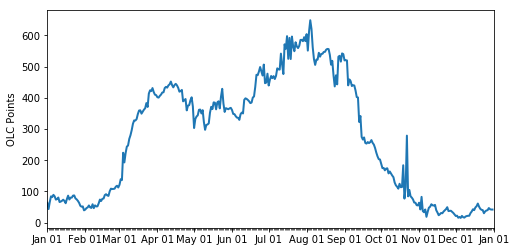

In [99]:
best_days = find_best_days(flights_table)
plot_days(best_days, start = datetime.datetime(2015, 1, 1), end = datetime.datetime(2016, 1, 1), smooth=7)